# Mineração de emoções em textos curtos

##### Trabalho feito por: Felipe Matheus Conceição da Silva, João Vitor Oliveira Cordeiro e Walan Marcel Teles Oliveira
##### Disciplina: Inteligência Artificial
##### Professor: Hendrik Macêdo

## Leitura de databases

In [1]:
arq = open('baseTreinamento.txt', 'r', encoding = 'latin-1')
entradaTreinamento = arq.readlines()
print("Linhas de treinamento: "+str(len(entradaTreinamento)))

arq = open('baseTeste.txt', 'r', encoding = 'latin-1')
entradaTeste = arq.readlines()
print("Linhas de teste: "+str(len(entradaTeste)))

baseTreinamento = list()
for linha in entradaTreinamento:
    linha = linha.split(":")
    linha[1] = linha[1].replace('\n', "")
    baseTreinamento.append(linha)
    
baseTeste = list()
for linha in entradaTeste:
    linha = linha.split(":")
    linha[1] = linha[1].replace('\n', "")
    baseTeste.append(linha)

print()
print("Exemplos: ")
print(baseTreinamento[0])
print(baseTeste[0])

Linhas de treinamento: 577
Linhas de teste: 228

Exemplos: 
['este trabalho e agradável', 'alegria']
['não precisei pagar o ingresso', 'alegria']


## Pré-processamento
### Remoção de stopwords e extração de radicais

In [2]:
stopwords = ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve', 'houvemos', 'houveram', 'houvera', 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse', 'houvéssemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei', 'houverá', 'houveremos', 'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 'somos', 'são', 'era', 'éramos', 'eram', 'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fôssemos', 'fossem', 'for', 'formos', 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos', 'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tivéramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem', 'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam', 'algum', 'alguma']

import nltk
stemmer = nltk.stem.RSLPStemmer()

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

tratadas = list()
for linha in baseTreinamento:
    frase = list()
    for palavra in linha[0].split():
        palavra = tokenizer.tokenize(palavra)[0]
        if palavra not in stopwords:
            frase.append(stemmer.stem(palavra))
    tratadas.append(frase)
#print(tratadas)

# Criação do dicionario
ficha = dict()
posicao = 0
linhas = 0
for frase in tratadas:
    linhas+=1
    for palavra in frase:
        if palavra not in ficha:
            ficha[palavra] = posicao
            posicao+=1
#print(ficha)

import numpy as np
matriz = np.zeros((linhas, posicao), dtype=np.int32)

i = -1
for frase in tratadas:
    i+=1
    for palavra in frase:
        j = ficha.get(palavra, -1)
        matriz[i][j] = 1

## Classes
#### Criação de dicionario para facilitar a construção de matrizes

In [3]:
classes = dict()
classes['alegria']  = 1
classes['desgosto'] = 2
classes['medo']     = 3
classes['raiva']    = 4
classes['surpresa'] = 5
classes['tristeza'] = 6

respostas = []
for i in range(len(baseTreinamento)):
    respostas.append(classes.get(baseTreinamento[i][1], 0))
    
newlist = list()
for i in classes.keys():
    newlist.append(i)

inversaClasses = dict()
for i in range(len(classes)):
    inversaClasses[i+1] = newlist[i]

## Multinomial
#### Implementação do Naive Bayes Multinomial

In [33]:
import numpy as np
class MultinomialNB(object):
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        count_sample = X.shape[0]
        separated = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        self.class_log_prior_ = [np.log(len(i) / count_sample) for i in separated]
        count = np.array([np.array(i).sum(axis=0) for i in separated]) + self.alpha
        self.feature_log_prob_ = np.log(count / count.sum(axis=1)[np.newaxis].T)
        return self

    def predict_log_proba(self, X):
        return [(self.feature_log_prob_ * x).sum(axis=1) + self.class_log_prior_ for x in X]

    def predict(self, X):
        return np.argmax(self.predict_log_proba(X), axis=1)+1

### Matriz treinamento
#### Criação de matriz usando as palavras da base de treinamento

In [34]:
auxiliar = []
for linha in matriz:
    auxiliar2 = []
    for item in linha[1:]:
        auxiliar2.append(item)
    auxiliar2.append(linha[0])
    auxiliar.append(auxiliar2)

In [35]:
# TREINAMENTO DE FATO
nb = MultinomialNB().fit(np.array(matriz), respostas)

## Teste de coerência
#### O classificador é posto a provas avaliando a própria base a qual foi treinado

In [7]:
saidas = []
for indi in range(len(auxiliar)):
    saidas.append(nb.predict(np.array([matriz[indi]])))

correct = 0
for i in range(len(auxiliar)):       
    if np.allclose(respostas[i], saidas[i]):
        correct += 1
        
multinomialCoerencia = ((correct/float(len(matriz))) * 100.0)
print("Multinomial- Coerência: %.2f"%multinomialCoerencia)

Multinomial- Coerência: 95.32


## Matriz Teste
#### É realizada a construção da matriz de teste a partir das frases base de teste

In [8]:
tratadasTeste = list()
for linha in baseTeste:
    frase = list()
    for palavra in linha[0].split():
        palavra = tokenizer.tokenize(palavra)[0]
        if palavra not in stopwords:
            frase.append(stemmer.stem(palavra))
    tratadasTeste.append(frase)

matrizTeste = np.zeros((len(baseTeste), posicao), dtype=np.int32)
i = -1
for frase in tratadasTeste:
    i+=1
    for palavra in frase:
        j = ficha.get(palavra, -1)
        if(j != -1):
            matrizTeste[i][j] = 1
    
respostasTeste = []
for frase in baseTeste:
    respostasTeste.append(classes.get(frase[1],0))

## Classificação da matriz de teste

In [9]:
saidasTeste = []
for indi in range(len(matrizTeste)):
    saidasTeste.append(nb.predict(np.array([matrizTeste[indi]])))

correct = 0
for i in range(len(matrizTeste)):       
    if np.allclose(respostasTeste[i], saidasTeste[i]):
        correct += 1
        
multinomialAcuracia = ((correct/float(len(matrizTeste))) * 100.0)

### Resultados

In [10]:
print("Linhas de treinamento: "+str(len(entradaTreinamento)))
print("Linhas de teste: "+str(len(entradaTeste)))
print("Quantidade de atributos: "+ str(len(ficha)))
print("Multinomial- Coerência: %.2f%%"%multinomialCoerencia)
print("Multinomial- Acurácia: %.2f%%"%multinomialAcuracia)

Linhas de treinamento: 577
Linhas de teste: 228
Quantidade de atributos: 824
Multinomial- Coerência: 95.32%
Multinomial- Acurácia: 47.81%


## Matriz de confusão do treinamento

In [11]:
classesObtidasTreinamento = []
classesGabaritoTreinamento = []
classesObtidasTeste = []
classesGabaritoTeste = []
for result in saidas:
    classesObtidasTreinamento.append(inversaClasses.get(int(result),0))
for result in respostas:
    classesGabaritoTreinamento.append(inversaClasses.get(int(result),0))
for result in saidasTeste:
    classesObtidasTeste.append(inversaClasses.get(int(result),0))
for result in respostasTeste:
    classesGabaritoTeste.append(inversaClasses.get(int(result),0))

Confusion matrix, without normalization
[[114   0   0   0   1   3]
 [  0  95   1   0   0   0]
 [  0   0  89   1   1   0]
 [  3   3   1  88   0   0]
 [  2   1   1   1  85   0]
 [  4   0   2   1   1  79]]
Normalized confusion matrix
[[ 0.97  0.    0.    0.    0.01  0.03]
 [ 0.    0.99  0.01  0.    0.    0.  ]
 [ 0.    0.    0.98  0.01  0.01  0.  ]
 [ 0.03  0.03  0.01  0.93  0.    0.  ]
 [ 0.02  0.01  0.01  0.01  0.94  0.  ]
 [ 0.05  0.    0.02  0.01  0.01  0.91]]


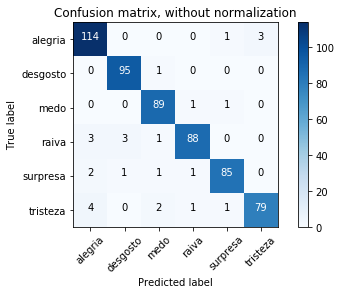

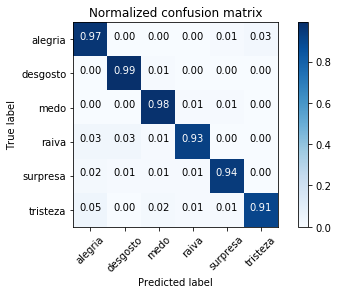

In [12]:
#Implementação fornecida pelo site abaixo
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = []
for cla in classes:
    class_names.append(cla)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrixTreinamento = confusion_matrix(classesGabaritoTreinamento, classesObtidasTreinamento)
cnf_matrixTeste = confusion_matrix(classesGabaritoTeste, classesObtidasTeste)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrixTreinamento, classes=class_names, title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrixTreinamento, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()

## Matriz de confusão do teste

Confusion matrix, without normalization
[[28  2  3 12  2  1]
 [ 8 18  2  2  3  3]
 [ 6  4 16  3  3  5]
 [ 5  1  6 17  1  6]
 [12  2  0  3 17  1]
 [11  4  5  3  0 13]]
Normalized confusion matrix
[[ 0.58  0.04  0.06  0.25  0.04  0.02]
 [ 0.22  0.5   0.06  0.06  0.08  0.08]
 [ 0.16  0.11  0.43  0.08  0.08  0.14]
 [ 0.14  0.03  0.17  0.47  0.03  0.17]
 [ 0.34  0.06  0.    0.09  0.49  0.03]
 [ 0.31  0.11  0.14  0.08  0.    0.36]]


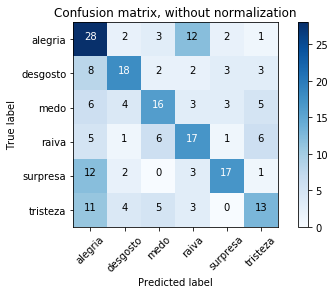

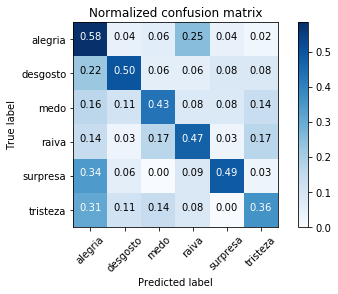

In [13]:
# Compute confusion matrix
cnf_matrixTeste = confusion_matrix(classesGabaritoTeste, classesObtidasTeste)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrixTeste, classes=class_names, title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrixTeste, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()

## Implementação do Naive Bayes Bernoulli

In [14]:
class BernoulliNB(object):
    def __init__(self, alpha=1.0, binarize=0.0):
        self.alpha = alpha
        self.binarize = binarize

    def fit(self, X, y):
        X = self._binarize_X(X)
        count_sample = X.shape[0]
        separated = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        self.class_log_prior_ = [np.log(len(i) / count_sample) for i in separated]
        count = np.array([np.array(i).sum(axis=0) for i in separated]) + self.alpha
        smoothing = 2 * self.alpha
        n_doc = np.array([len(i) + smoothing for i in separated])
        self.feature_prob_ = count / n_doc[np.newaxis].T
        return self

    def predict_log_proba(self, X):
        X = self._binarize_X(X)
        return [(np.log(self.feature_prob_) * x + \
                 np.log(1 - self.feature_prob_) * np.abs(x - 1)
                ).sum(axis=1) + self.class_log_prior_ for x in X]

    def predict(self, X):
        X = self._binarize_X(X)
        return np.argmax(self.predict_log_proba(X), axis=1)+1
    
    def _binarize_X(self, X):
        return np.where(X > self.binarize, 1, 0) if self.binarize != None else X

In [16]:
bnb = BernoulliNB(alpha=1).fit(np.array(matriz), respostas)
#print(bnb.feature_prob_)
saidasb = []
for indi in range(len(matriz)):
    saidasb.append(bnb.predict(np.array([matriz[indi]])))

correct = 0
for i in range(len(matriz)):       
    if np.allclose(respostas[i], saidasb[i]):
        correct += 1
print("Bernoulli- Coerência: %.2f"%((correct/float(len(matriz))) * 100.0))

Bernoulli- Coerência: 73.83


In [17]:
saidasTesteB = []
for indi in range(len(matrizTeste)):
    saidasTesteB.append(bnb.predict(np.array([matrizTeste[indi]])))

correct = 0
for i in range(len(matrizTeste)):       
    if np.allclose(respostasTeste[i], saidasTesteB[i]):
        correct += 1
print("Bernoulli- Acurácia: %.2f"%((correct/float(len(matrizTeste))) * 100.0))

Bernoulli- Acurácia: 31.58


## Matrizes de confusão do treinamento e teste da codificação Bernoulli

In [18]:
classesObtidasTreinamento = []
classesGabaritoTreinamento = []
classesObtidasTeste = []
classesGabaritoTeste = []
for result in saidasb:
    classesObtidasTreinamento.append(inversaClasses.get(int(result),0))
for result in respostas:
    classesGabaritoTreinamento.append(inversaClasses.get(int(result),0))
for result in saidasTesteB:
    classesObtidasTeste.append(inversaClasses.get(int(result),0))
for result in respostasTeste:
    classesGabaritoTeste.append(inversaClasses.get(int(result),0))

Confusion matrix, without normalization
[[118   0   0   0   0   0]
 [ 18  77   0   1   0   0]
 [ 24   1  62   3   1   0]
 [ 24   3   0  68   0   0]
 [ 28   1   0   2  59   0]
 [ 40   0   1   3   1  42]]
Normalized confusion matrix
[[ 1.    0.    0.    0.    0.    0.  ]
 [ 0.19  0.8   0.    0.01  0.    0.  ]
 [ 0.26  0.01  0.68  0.03  0.01  0.  ]
 [ 0.25  0.03  0.    0.72  0.    0.  ]
 [ 0.31  0.01  0.    0.02  0.66  0.  ]
 [ 0.46  0.    0.01  0.03  0.01  0.48]]


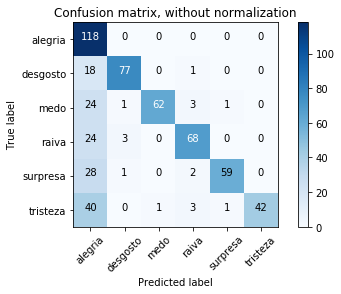

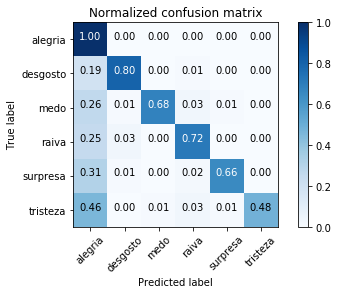

In [21]:
# Compute confusion matrix
cnf_matrixTreinamento = confusion_matrix(classesGabaritoTreinamento, classesObtidasTreinamento)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrixTreinamento, classes=class_names, title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrixTreinamento, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[42  1  0  5  0  0]
 [23 11  0  2  0  0]
 [27  3  4  1  1  1]
 [24  1  2  8  0  1]
 [30  0  0  1  4  0]
 [32  0  0  1  0  3]]
Normalized confusion matrix
[[ 0.88  0.02  0.    0.1   0.    0.  ]
 [ 0.64  0.31  0.    0.06  0.    0.  ]
 [ 0.73  0.08  0.11  0.03  0.03  0.03]
 [ 0.67  0.03  0.06  0.22  0.    0.03]
 [ 0.86  0.    0.    0.03  0.11  0.  ]
 [ 0.89  0.    0.    0.03  0.    0.08]]


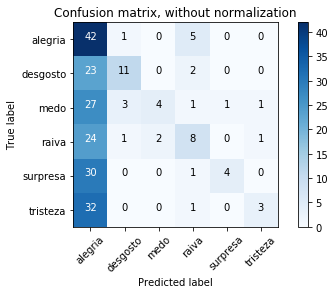

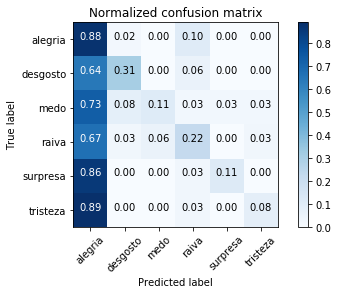

In [22]:
cnf_matrixTeste = confusion_matrix(classesGabaritoTeste, classesObtidasTeste)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrixTeste, classes=class_names, title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrixTeste, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()

## Random Forests

In [23]:
X_train = np.array(matriz)[:,1:]
y_train = np.array(matriz)[:,0]

from sklearn.ensemble import RandomForestClassifier


feat_labels = []
for key in ficha:
    feat_labels.append(key)

forest = RandomForestClassifier(n_estimators=75,
                                criterion='entropy',
                                max_features='sqrt',
                                random_state=1,
                                n_jobs=-1)

forest.fit(matriz, respostas)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) surpreend                      0.015957
 2) acredit                        0.012034
 3) vou                            0.010228
 4) perig                          0.009989
 5) deslumbr                       0.008987
 6) am                             0.008235
 7) socorr                         0.008144
 8) depress                        0.007522
 9) real                           0.007334
10) cuid                           0.007225
11) voc                            0.006343
12) tão                            0.006270
13) mim                            0.006266
14) trist                          0.006226
15) grand                          0.006142
16) nad                            0.006107
17) est                            0.006024
18) mat                            0.006003
19) maravilh                       0.005853
20) abat                           0.005788
21) favor                          0.005654
22) hoj                            0.005467
23) dinh                        

530) dar                            0.000465
531) próx                           0.000463
532) ofens                          0.000463
533) cuidad                         0.000462
534) crim                           0.000461
535) abundanc                       0.000460
536) morr                           0.000459
537) traz                           0.000459
538) vem                            0.000458
539) ranc                           0.000458
540) fet                            0.000457
541) machuc                         0.000456
542) gross                          0.000455
543) adentr                         0.000454
544) companh                        0.000454
545) entr                           0.000454
546) repent                         0.000451
547) gat                            0.000449
548) crucific                       0.000445
549) asc                            0.000444
550) assedi                         0.000442
551) rua                            0.000437
552) ceu  

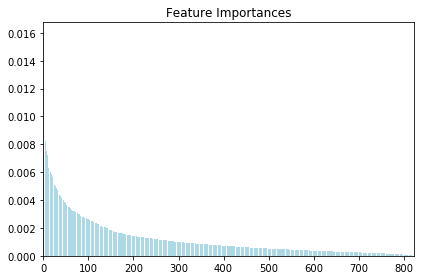

In [24]:
import numpy as np 
import matplotlib.pyplot as plt
plt.title('Feature Importances')
plt.bar(range(matriz.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

#plt.xticks(range(X_train.shape[1]), 
#           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [26]:
#Demora um pouco para predizer todas as frases
predicao = []
qMt = len(matriz)
for j in range(qMt):
    #print(j, end="")
    z = []
    aux0 = []
    for i in range(len(matriz[j])):
        aux0.append(matriz[j][i])
    z.append(np.array(aux0))
    predicao.append(forest.predict(z))
    #print(".", end="")
print()

In [27]:
corretos = 0
for i in range(len(predicao)):
    if(int(predicao[i]) == int(respostas[i])):
        corretos+=1
print("Coerencia Matriz Treinamento = %.2f"%(float(corretos/len(predicao))*100))

Coerencia Matriz Treinamento = 99.83


In [28]:
predicaoTeste = []
quant = len(matrizTeste)
#quant = 20
for j in range(quant):
    #print(j, end=".")
    z = []
    aux0 = []
    for i in range(len(matrizTeste[j])):
        aux0.append(matrizTeste[j][i])
    z.append(np.array(aux0))
    predicaoTeste.append(forest.predict(z))
print()

In [29]:
corretos = 0
for i in range(len(predicaoTeste)):
    if(int(predicaoTeste[i]) == int(respostasTeste[i])):
        corretos+=1
print("Acuracia = %.2f"%(float(corretos/len(predicaoTeste))*100))

Acuracia = 32.89
